# Complete Pipeline
This notebook contains the step-by-step implementation of our assigned paper.

In [1]:
# importing necessary python packages
from FastSingleImageReflectionSuppression.inv import fastInvReflectionSuppression
import numpy as np
import cv2
import matplotlib.pyplot as plt

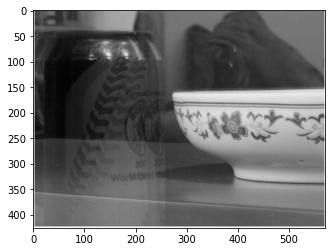

In [2]:
# reading the image that we use as input for reflection removal
img = cv2.imread('./imgs/img.png', 0)
plt.imshow(img[:, ::-1], cmap='gray')

## Step 1: _Shift Amount Determination_
-  We have an image `im`
-  It has a reflection caused by a glass surface
-  We take canny edge of the image and look for a shifted match

    <img src="../documents/imgs/Reflection.jpeg" width= "350" height= "325">

What does this mean? Once we get the edges, the reflection follows a ghost effect (two reflections are produced because of the glass) This would mean that a template matching algorithm (like a hit/miss) would give a maximum at the shifted postion. Using this we can determine factor `d` which is the shift. There is definitely going to be some attenuation, i.e., the second reflection will have lower intensity than the first, because the glass absorbs more energy from the light that eventually creates the second reflection (notice that the ray spends longer inside the glass).

### Why edges?
In theory, we have modelled the image as a vector addition of 3 terms, the scene image, the first reflection and the shifted reflection. This isn't be directly separable in the image domain because we don't know which pixel is assigned to the scene image and which one goes to the reflections. In the edge-domain, there is not much overlap between the scene edges and the reflection edges. 

38


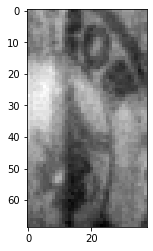

In [3]:
# selecting a portion of weaker reflection as template  
templateBox = [[183,313],[252,351]]
print(templateBox[1][1] - templateBox[0][1])
template = img[templateBox[0][0]: templateBox[1][0], templateBox[0][1]: templateBox[1][1]]
plt.imshow(img[templateBox[0][0]: templateBox[1][0], templateBox[0][1]: templateBox[1][1]], cmap='gray')

9580.194


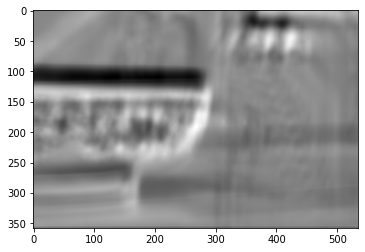

In [4]:
# running template matching on the input image against the template
img2 = img.copy()
res = cv2.matchTemplate(img,template,cv2.TM_CCOEFF)
plt.imshow(res,cmap = 'gray')
print(np.median(res))

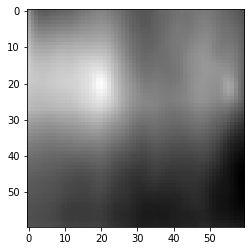

In [5]:
# zooming in to the result of the template matching
mid = np.zeros(2).astype(int)
for i in templateBox:
    for j in range(2):
        mid[j] += i[j]/2

mid = templateBox[0]
plt.imshow(res[mid[0]-20:mid[0]+40, mid[1]-20:mid[1]+40],cmap= 'gray')

In [6]:
# checking a nearby neighbourhood and thresholding 
sL = sorted(res[mid[0]-40:mid[0]+40, mid[0]-40:mid[0]+40].flatten())
a = np.array(np.where(res != 0))
a = a.T
b = [i for i in a if i[0] >= templateBox[0][0] -10 and i[0] <= templateBox[1][0] + 10]
b = [i for i in b if i[1] >= templateBox[0][1] -10 and i[1] <= templateBox[1][1] + 10]


[183, 313]


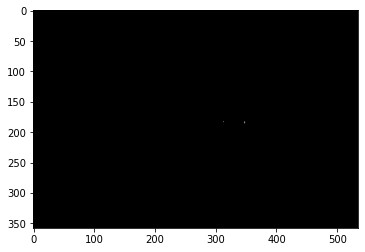

In [7]:
# result of thresholding 
r = np.zeros_like(res)
for i, j in b:
    r[i, j] = res[i, j]

r1 = (r > np.max(r)/3)
r2 = r1.copy()
r2[:,:320] = 0
r2[mid[0]][mid[1]] = 1
plt.imshow(r2,cmap='gray')
print(mid)


In [8]:
w = np.array(np.where(r2 == 1)).T
shift = 0
for i in w:
    for j in w:
        shift = max(shift, np.abs(i[1] - j[1]))

shift

35

## Step 2: _Gradient Separation_
Now that we have info on the shift, we can proceed with separating the Gradient.

We have the information pertaining to the expected shift, which means, everytime we come across a gradient, if we check $arg + \vec{d}$ and $arg - \vec{d}$ and if they correspond to maxima too, then we assign that particular pixel to the reflection image.


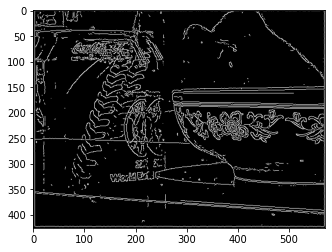

In [9]:
# c2 = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=7)
img = cv2.imread('./imgs/img.png', 0)
c2 = cv2.Canny(img,43,53)
c2 = c2[..., ::-1]
c2 = c2 >= 255
imgRev = img[..., ::-1]
c2 = c2 * 255
# c2 = auto_canny(imgRev, 0)
plt.imshow(c2, cmap='gray')

In [10]:
from tqdm import tqdm
def do_template_matching(im,kernel):
    return cv2.matchTemplate(im,kernel,cv2.TM_CCOEFF)

# modified template matching to find reflection edges
def takeTemplatematch(edges, img,d,k=30, maxVal=255):
    M, N = edges.shape
    ret = np.zeros_like(edges)
    where = np.array(np.where(edges == 255)).T
    where = [i for i in where if i[0] < M-k-d[0] and i[1] < N-k-d[1] and i[0] > d[0]+ 5 and i[1] >d[1] + 5]

    for i, j in tqdm(where):
        temp = img[i:i+k,j:j+k]
        t = do_template_matching(img,temp)
        # how to modify __ because shapes are different. To be ironed out.
        # if (t[i - d[0],j - d[1]] >= thresh or t[i + d[0],j + d[1]] >= thresh):
        if t[i-d[0], j-d[1]] >= np.max(t[i-d[0]-5:i-d[0]+5,j-d[1]-5:j-d[1]+5]) / 1.15:
            ret[i, j] = 1
        if t[i+d[0], j+d[1]] >= np.max(t[i+d[0]-5:i+d[0]+5,j+d[1]-5:j+d[1]+5]) / 1.15:
            ret[i, j] = 1
    return ret*maxVal


In [11]:
r = takeTemplatematch(c2,imgRev, np.array([0, 35]))

100%|██████████| 14191/14191 [00:55<00:00, 256.12it/s]


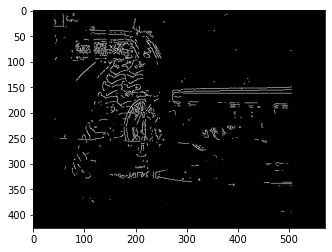

In [12]:
plt.imshow(r, cmap='gray')

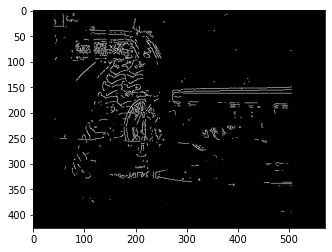

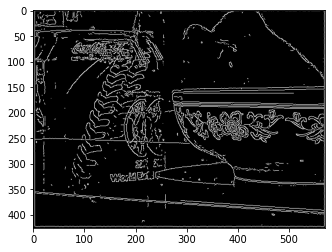

In [13]:
rr = r.copy()
# rr[:, 250:] = 0
plt.imshow(rr, cmap='gray')
plt.show()
plt.imshow(c2, cmap='gray')
plt.show()


## Step 3: _Image Reconstruction_
Function = Edge = thresholded dervivative
*Step 1* : Find which kernel f(x,y) will act as the thresholded derivative when convolved with an image, ie: f(x,y) * image = edge image (figure out for canny, or we will roll with simple derivative operator and scrap canny)



*Step 2* : perform the following:

$f1 = f(-x,-y)  \\$
$h = \mathfrak{F}( f1 * f) \\$
$g = \mathfrak{F}^{-1}( \text{ones}(\text{image shape}) / h) \\$
$Out = g*f1*(\text{edge image}) \\$

100%|██████████| 426/426 [00:00<00:00, 545.78it/s]

3


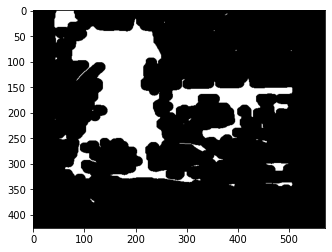

In [14]:
from utils import fillHoles

closing = cv2.morphologyEx(rr.astype(np.uint8), cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (20, 20)))

closing = fillHoles(closing//255, 1000)
plt.imshow(closing, cmap='gray')


100%|██████████| 426/426 [00:00<00:00, 2242.90it/s]


33


100%|██████████| 33/33 [00:00<00:00, 3501.71it/s]


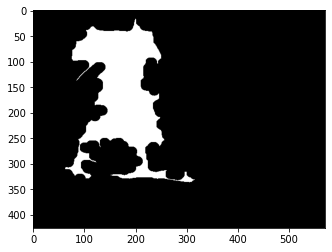

In [15]:
# under the assumption that there is only one reflected object, which is the case with the original paper.
import utils
regions = utils.getRegions(closing)
gr = 0
grReg = -1
for i in tqdm(np.unique(regions)):
    if i == 0: 
        continue
    if np.sum(regions == i) > gr:
        gr = np.sum(regions == i)
        grReg = i

m = regions == grReg
mask = m[:, ::-1]

plt.imshow(m, cmap='gray')

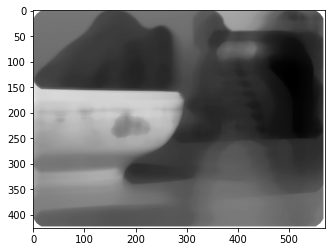

In [16]:
medianIMG = cv2.medianBlur(img, 31)
plt.imshow(medianIMG, cmap='gray')
plt.show()

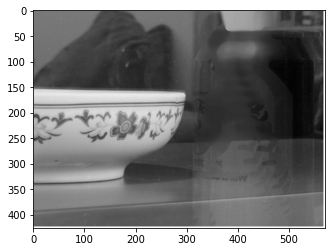

In [17]:
plt.imshow(mask*medianIMG + (np.ones_like(mask) ^  mask) * img, cmap='gray')

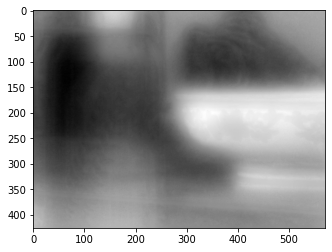

In [18]:
invFRR = fastInvReflectionSuppression(cv2.cvtColor(img, cv2.COLOR_GRAY2RGB), 0.015)
invFRR /= invFRR.max()
invFRR = np.clip(invFRR * 255, 0, 255)
invFRR = invFRR.astype(np.uint8)
invFRR = cv2.cvtColor(invFRR, cv2.COLOR_RGB2GRAY)

plt.imshow(invFRR[:, ::-1], cmap='gray')

True


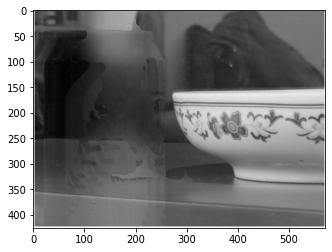

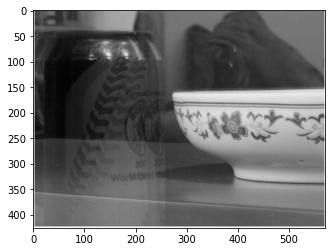

In [19]:
res = np.zeros_like(img)
print(np.max(mask))
res = mask*invFRR + (np.ones_like(mask) ^  mask) * img
plt.imshow(res[:, ::-1], cmap='gray')
plt.show()
plt.imshow(img[:, ::-1], cmap='gray')